In [2]:
import pandas as pd
import mne
mne.viz.set_browser_backend('qt')
from autoreject import AutoReject
import numpy as np
import matplotlib.pyplot as plt

import sys
sys.path.append('../src')

from utils.load_data import load_metadata, load_trial, get_dataset_split

import warnings
warnings.filterwarnings("ignore")

Using qt as 2D backend.


Loading Metadata

In [3]:
base_path = '../data/raw'
train = load_metadata(base_path)['train']

In [4]:
train.head()

,id,subject_id,task,trial_session,trial,label
0,1,S1,MI,1,1,Left
1,2,S1,MI,1,2,Right
2,3,S1,MI,1,3,Left
3,4,S1,MI,1,4,Left
4,5,S1,MI,1,5,Left


Checking acceleration and rotation thresholds.

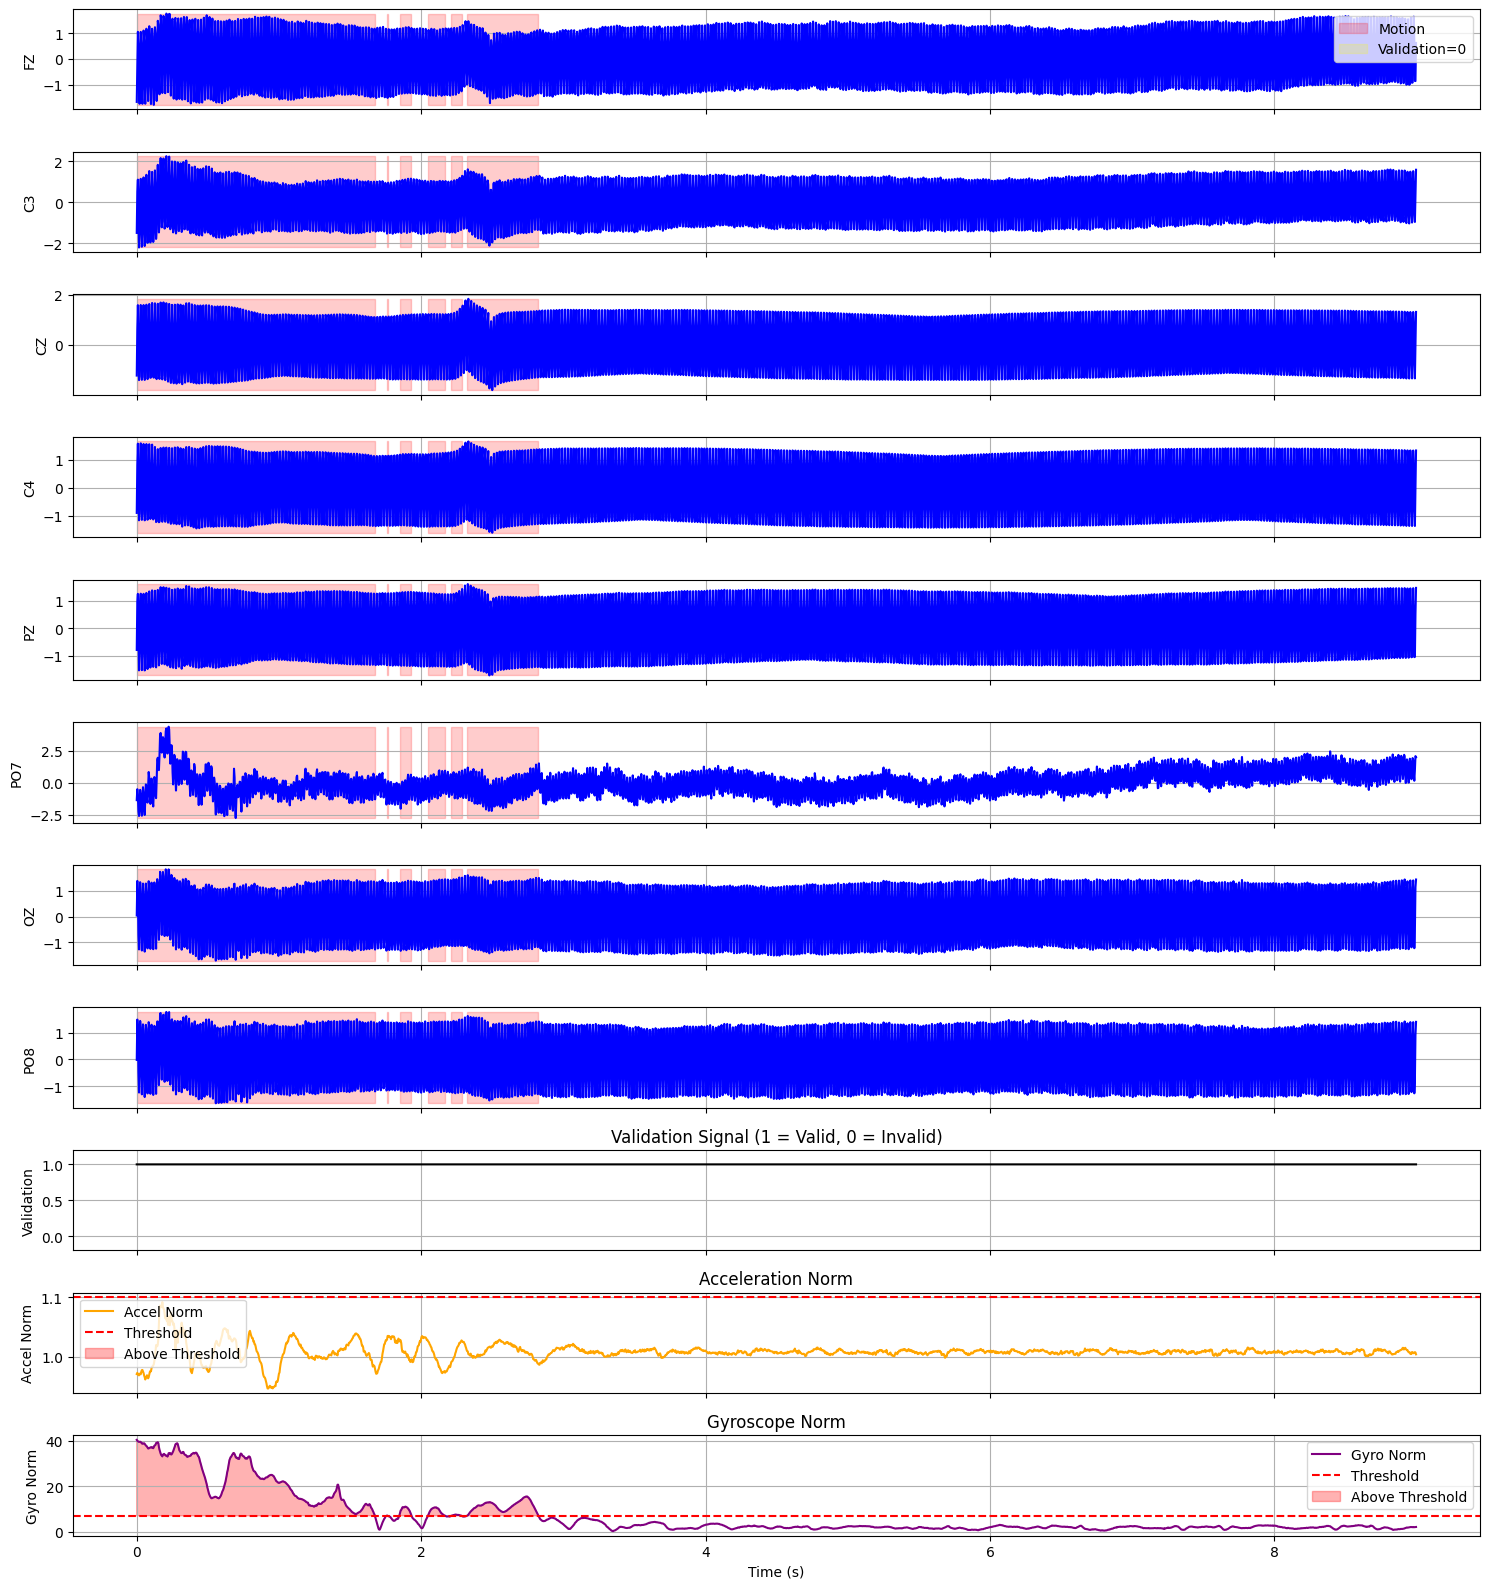

In [5]:
# Load the trial and compute norms
trial = train.iloc[50]
trial_data = load_trial(trial, get_dataset_split(trial['id']), base_path)

eeg_channels = ['FZ', 'C3', 'CZ', 'C4', 'PZ', 'PO7', 'OZ', 'PO8']
accel_norm = np.linalg.norm(trial_data[['AccX', 'AccY', 'AccZ']].values, axis=1)
gyro_norm = np.linalg.norm(trial_data[['Gyro1', 'Gyro2', 'Gyro3']].values, axis=1)
validation = trial_data['Validation'].values

sfreq = 250  # Hz
time = np.arange(len(accel_norm)) / sfreq

# Normalize EEG for plotting (z-score each channel)
eeg_data = trial_data[eeg_channels].apply(lambda ch: (ch - ch.mean()) / ch.std(), axis=0)

# Motion thresholds
accel_thresh = 1.1
gyro_thresh = 7

# Boolean masks for motion artifacts and validation failures
motion_mask = (accel_norm > accel_thresh) | (gyro_norm > gyro_thresh)
validation_mask = (validation == 0)

# Create subplots: 8 EEG channels + Validation + Accel + Gyro = 11
fig, axs = plt.subplots(len(eeg_channels) + 3, 1, figsize=(15, 16), sharex=True)

# --- Plot EEG channels with background highlighting ---
for i, ch in enumerate(eeg_channels):
    axs[i].plot(time, eeg_data[ch], color='blue')
    axs[i].set_ylabel(ch)
    axs[i].grid(True)

    # Highlight motion artifacts
    axs[i].fill_between(time, eeg_data[ch].min(), eeg_data[ch].max(),
                        where=motion_mask,
                        color='red', alpha=0.2, label='Motion')

    # Highlight validation failure
    axs[i].fill_between(time, eeg_data[ch].min(), eeg_data[ch].max(),
                        where=validation_mask,
                        color='yellow', alpha=0.2, label='Validation=0')

    # Add legend only to first plot
    if i == 0:
        axs[i].legend(loc='upper right')

# --- Validation Plot ---
axs[-3].plot(time, validation, drawstyle='steps-pre', color='black')
axs[-3].set_ylim(-0.2, 1.2)
axs[-3].set_ylabel("Validation")
axs[-3].set_title("Validation Signal (1 = Valid, 0 = Invalid)")
axs[-3].grid(True)

# --- Accel Norm Plot ---
axs[-2].plot(time, accel_norm, color='orange', label='Accel Norm')
axs[-2].axhline(accel_thresh, color='red', linestyle='--', label='Threshold')
axs[-2].fill_between(time, accel_norm, accel_thresh,
                     where=accel_norm > accel_thresh,
                     color='red', alpha=0.3, label='Above Threshold')
axs[-2].set_ylabel("Accel Norm")
axs[-2].set_title("Acceleration Norm")
axs[-2].legend()
axs[-2].grid(True)

# --- Gyro Norm Plot ---
axs[-1].plot(time, gyro_norm, color='purple', label='Gyro Norm')
axs[-1].axhline(gyro_thresh, color='red', linestyle='--', label='Threshold')
axs[-1].fill_between(time, gyro_norm, gyro_thresh,
                     where=gyro_norm > gyro_thresh,
                     color='red', alpha=0.3, label='Above Threshold')
axs[-1].set_ylabel("Gyro Norm")
axs[-1].set_xlabel("Time (s)")
axs[-1].set_title("Gyroscope Norm")
axs[-1].legend()
axs[-1].grid(True)

plt.tight_layout()
plt.show()

Function for returning an annotated `mne.io.RawArray` object.

In [42]:
def preprocess_trial(trial_data, accel_thresh=1.1, gyro_thresh=7, sfreq_eeg=250, battery_threshold=10):
    """
    Preprocesses and converts a single trial CSV to an MNE RawArray.
    Includes quality control based on validation, battery, motion, and EEG amplitude.
    """

    # Define channel names and types
    eeg_channels = ['FZ', 'C3', 'CZ', 'C4', 'PZ', 'PO7', 'OZ', 'PO8']
    aux_channels = ['AccX', 'AccY', 'AccZ', 'Gyro1', 'Gyro2', 'Gyro3', 'Validation', 'Battery']
    all_ch_names = eeg_channels + aux_channels
    ch_types = ['eeg'] * len(eeg_channels) + ['misc'] * len(aux_channels)

    info = mne.create_info(ch_names=all_ch_names, sfreq=sfreq_eeg, ch_types=ch_types)

    # ⚠️ Convert EEG from µV to V
    trial_data_scaled = trial_data.copy()
    trial_data_scaled[eeg_channels] *= 1e-6  # µV → V

    # RawArray expects (n_channels, n_times)
    eeg_data = trial_data_scaled[all_ch_names].values.T
    raw = mne.io.RawArray(eeg_data, info, verbose=False)
    raw.rename_channels({'FZ': 'Fz', 'CZ': 'Cz', 'PZ': 'Pz', 'OZ': 'Oz'})
    raw.set_montage('standard_1020')

    onsets, durations, descriptions = [], [], []

    # --- Annotate: bad validation ---
    bad_signal_indices = np.where(trial_data['Validation'] == 0)[0]
    if bad_signal_indices.size > 0:
        diff = np.diff(bad_signal_indices)
        breaks = np.where(diff != 1)[0] + 1
        segments = np.split(bad_signal_indices, breaks)
        for seg in segments:
            onsets.append(float(raw.times[seg[0]]))
            durations.append(len(seg) / sfreq_eeg)
            descriptions.append("bad_signal_quality")

    # --- Annotate: low battery ---
    low_battery_indices = np.where(trial_data['Battery'] < battery_threshold)[0]
    if low_battery_indices.size > 0:
        diff = np.diff(low_battery_indices)
        breaks = np.where(diff != 1)[0] + 1
        segments = np.split(low_battery_indices, breaks)
        for seg in segments:
            onsets.append(float(raw.times[seg[0]]))
            durations.append(len(seg) / sfreq_eeg)
            descriptions.append("bad_battery_level")

    # --- Annotate: high acceleration ---
    acc_norm = np.linalg.norm(trial_data[['AccX', 'AccY', 'AccZ']].values, axis=1)
    acc_motion_indices = np.where(acc_norm > accel_thresh)[0]
    if acc_motion_indices.size > 0:
        diff = np.diff(acc_motion_indices)
        breaks = np.where(diff != 1)[0] + 1
        segments = np.split(acc_motion_indices, breaks)
        for seg in segments:
            onsets.append(float(raw.times[seg[0]]))
            durations.append(len(seg) / sfreq_eeg)
            descriptions.append("bad_acceleration_motion")

    # --- Annotate: high gyroscope motion ---
    gyro_norm = np.linalg.norm(trial_data[['Gyro1', 'Gyro2', 'Gyro3']].values, axis=1)
    gyro_motion_indices = np.where(gyro_norm > gyro_thresh)[0]
    if gyro_motion_indices.size > 0:
        diff = np.diff(gyro_motion_indices)
        breaks = np.where(diff != 1)[0] + 1
        segments = np.split(gyro_motion_indices, breaks)
        for seg in segments:
            onsets.append(float(raw.times[seg[0]]))
            durations.append(len(seg) / sfreq_eeg)
            descriptions.append("bad_gyro_motion")

    # --- Set all annotations ---
    if onsets:
        annotations = mne.Annotations(onset=onsets, duration=durations, description=descriptions,
                                      orig_time=raw.info['meas_date'])
        raw.set_annotations(annotations)
        return raw, annotations
    else:
        return raw, None

Plotting functions

In [7]:
def plot_preprocessed_trial(raw_object, duration=10, start=0.0):
    raw_object.copy().plot(duration=duration, start=start, n_channels=8, scalings='auto', show=True)
    
def plot_preprocessed_trial_psd(raw_object, fmin=1, fmax=60, dB=True):
    psd = raw_object.copy().compute_psd(fmin=fmin, fmax=fmax)
    psd.plot(dB=dB, picks='eeg')
    # plt.show()

In [41]:
trial = train.iloc[0]
trial_data = load_trial(trial, get_dataset_split(trial['id']), base_path)
plot_preprocessed_trial(preprocess_trial(trial_data)[0])

Channels marked as bad:
none


Setting 141 of 2250 (6.27%) samples to NaN, retaining 2109 (93.73%) samples.
Effective window size : 8.192 (s)
At least one good data span is shorter than n_per_seg, and will be analyzed with a shorter window than the rest of the file.
Plotting power spectral density (dB=True).


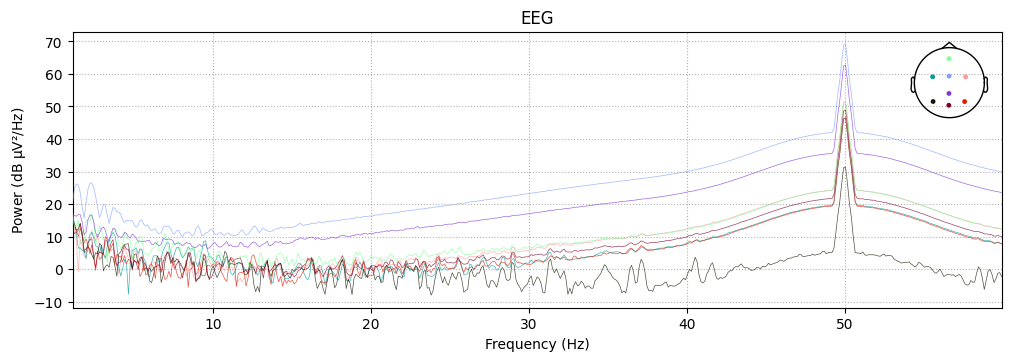

In [40]:
trial = train.iloc[0]
trial_data = load_trial(trial, get_dataset_split(trial['id']), base_path)
plot_preprocessed_trial_psd(preprocess_trial(trial_data)[0])

Applying notch filters to remove power line interference.

Setting 141 of 2250 (6.27%) samples to NaN, retaining 2109 (93.73%) samples.
Effective window size : 8.192 (s)
At least one good data span is shorter than n_per_seg, and will be analyzed with a shorter window than the rest of the file.
Plotting power spectral density (dB=True).


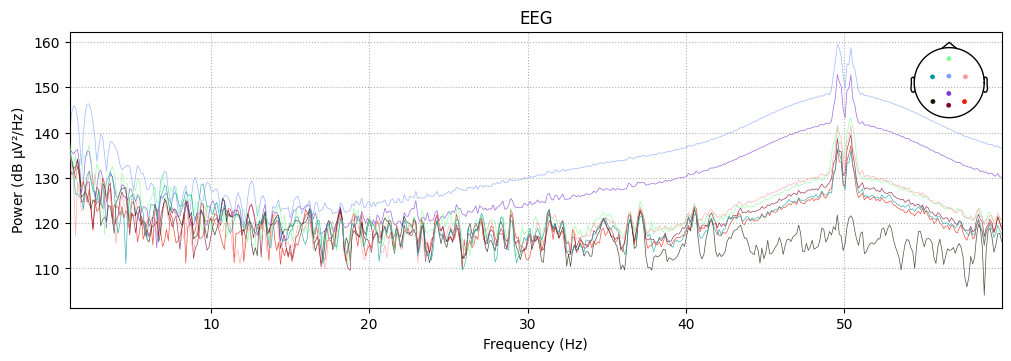

In [10]:
trial = train.iloc[0]
trial_data = load_trial(trial, get_dataset_split(trial['id']), base_path)
trial_raw, annotations = preprocess_trial(trial_data)

trial_raw.notch_filter(freqs=50, picks='eeg', fir_design='firwin', verbose=False)

plot_preprocessed_trial_psd(trial_raw)

Applying band-pass filtering.

Setting 141 of 2250 (6.27%) samples to NaN, retaining 2109 (93.73%) samples.
Effective window size : 8.192 (s)
At least one good data span is shorter than n_per_seg, and will be analyzed with a shorter window than the rest of the file.
Plotting power spectral density (dB=True).


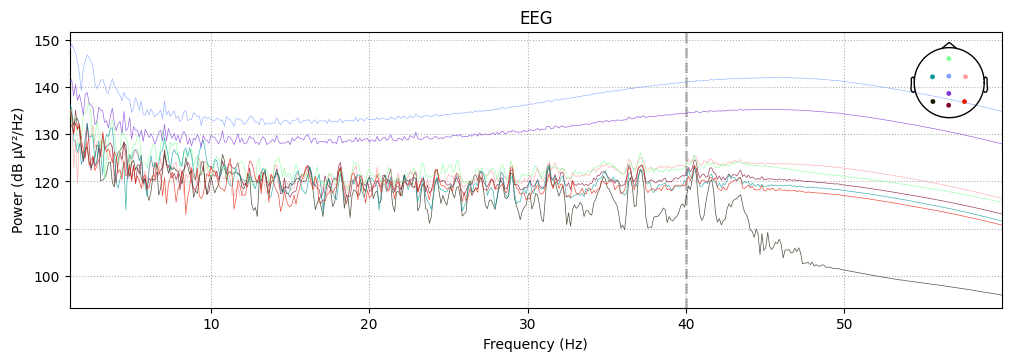

In [11]:
trial = train.iloc[0]
trial_data = load_trial(trial, get_dataset_split(trial['id']), base_path)
trial_raw, annotations = preprocess_trial(trial_data)

trial_raw.notch_filter(freqs=50, picks='eeg', fir_design='firwin', verbose=False)

trial_raw.filter(l_freq=1, h_freq=40, picks='eeg', verbose=False)

plot_preprocessed_trial_psd(trial_raw)

In [49]:
trial = train.iloc[7]
trial_data = load_trial(trial, get_dataset_split(trial['id']), base_path)
trial_raw, annotations = preprocess_trial(trial_data)

trial_raw.set_eeg_reference('average', verbose=False)


trial_raw.notch_filter(freqs=50, picks='eeg', fir_design='firwin', verbose=False)

trial_raw.filter(l_freq=1, h_freq=40, picks='eeg', verbose=False)

plot_preprocessed_trial(trial_raw)

Channels marked as bad:
none


Resampling the data for quick `ICA`.

Setting 49 of 810 (6.05%) samples to NaN, retaining 761 (93.95%) samples.
Effective window size : 9.000 (s)
At least one good data span is shorter than n_per_seg, and will be analyzed with a shorter window than the rest of the file.
Plotting power spectral density (dB=True).


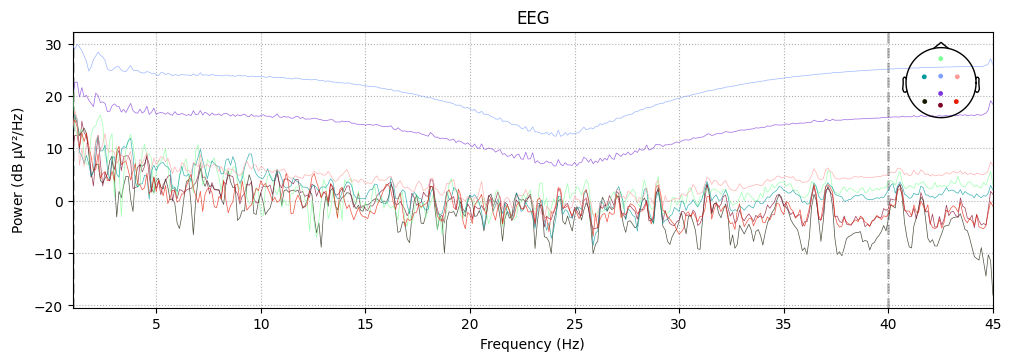

In [43]:
trial = train.iloc[0]
trial_data = load_trial(trial, get_dataset_split(trial['id']), base_path)
trial_raw, annotations = preprocess_trial(trial_data)

trial_raw.notch_filter(freqs=50, picks='eeg', fir_design='firwin', verbose=False)

trial_raw.filter(l_freq=1, h_freq=40, picks='eeg', verbose=False)

trial_raw_resampled = trial_raw.copy().resample(90, npad='auto', method='fft') # Resampling a copy of the data to not lose information
plot_preprocessed_trial_psd(trial_raw_resampled, fmax=45)

In [ ]:
trial = train.iloc[0]
trial_data = load_trial(trial, get_dataset_split(trial['id']), base_path)
trial_raw, annotations = preprocess_trial(trial_data)

trial_raw.set_eeg_reference('average', verbose=False)

trial_raw.notch_filter(freqs=50, picks='eeg', fir_design='firwin', verbose=False)

trial_raw.filter(l_freq=1, h_freq=40, picks='eeg', verbose=False)

trial_raw_resampled = trial_raw.copy().resample(90, npad='auto', method='fft') # Resampling a copy of the data to not lose information
plot_preprocessed_trial(trial_raw_resampled)

Channels marked as bad:
none
Channels marked as bad:
none


In [134]:
one_subject = train[
    (train['subject_id'] == 'S1') &
    (train['task'] == 'MI')
]

one_subject.shape

(80, 6)

In [135]:
all_raws = []
for _, row in one_subject.iterrows():
    trial_data = load_trial(row, get_dataset_split(row['id']), base_path)
    trial_raw, annotations = preprocess_trial(trial_data)
    all_raws.append(trial_raw)

In [136]:
# 1. Acquire all subject raws
subject_raw = mne.concatenate_raws(all_raws)

# 2. Bandpass, notch, reference, etc.
subject_raw.set_eeg_reference('average', verbose=False)
subject_raw.notch_filter(freqs=50, picks='eeg', fir_design='firwin', verbose=False)
subject_raw.filter(l_freq=1, h_freq=40, picks='eeg', verbose=False)
subject_raw_resampled = subject_raw.copy().resample(90, npad='auto', method='fft') # Resampling a copy of the data to not lose information

# 3. ICA
ica = mne.preprocessing.ICA(n_components=8, random_state=42)
ica.fit(subject_raw_resampled)

Fitting ICA to data using 8 channels (please be patient, this may take a while)
Omitting 1940 of 64800 (2.99%) samples, retaining 62860 (97.01%) samples.
Selecting by number: 8 components
Fitting ICA took 0.8s.


Method,fastica
Fit parameters,algorithm=parallelfun=logcoshfun_args=Nonemax_iter=1000
Fit,29 iterations on raw data (62860 samples)
ICA components,8
Available PCA components,8
Channel types,eeg
ICA components marked for exclusion,—


In [137]:
ica.plot_components()
plt.show()

In [130]:
plot_preprocessed_trial(subject_raw)

Channels marked as bad:
none


In [138]:
plot_preprocessed_trial(subject_raw_resampled)

In [139]:
ica.plot_sources(subject_raw_resampled)

Creating RawArray with float64 data, n_channels=8, n_times=64800
    Range : 0 ... 64799 =      0.000 ...   719.989 secs
Ready.


In [ ]:
subject_raw_resampled_ica = subject_raw_resampled.copy()
ica.exclude = [4, 3, 2]  # or use ICA.auto_detect, EOG channel, etc.
ica.apply(subject_raw_resampled_ica)

plot_preprocessed_trial(subject_raw_resampled_ica)

Applying ICA to Raw instance
    Transforming to ICA space (8 components)
    Zeroing out 3 ICA components
    Projecting back using 8 PCA components


Channels marked as bad:
none
Channels marked as bad:
none


In [142]:
ica.plot_properties(subject_raw_resampled_ica)

    Using multitaper spectrum estimation with 7 DPSS windows
Not setting metadata
2 matching events found
No baseline correction applied
0 projection items activated
Not setting metadata
2 matching events found
No baseline correction applied
0 projection items activated
Not setting metadata
2 matching events found
No baseline correction applied
0 projection items activated
Not setting metadata
2 matching events found
No baseline correction applied
0 projection items activated
Not setting metadata
2 matching events found
No baseline correction applied
0 projection items activated
Not setting metadata
2 matching events found
No baseline correction applied
0 projection items activated
Not setting metadata
2 matching events found
No baseline correction applied
0 projection items activated
Not setting metadata
2 matching events found
No baseline correction applied
0 projection items activated
Not setting metadata
2 matching events found
No baseline correction applied
0 projection items acti

[<Figure size 700x600 with 6 Axes>,
 <Figure size 700x600 with 6 Axes>,
 <Figure size 700x600 with 6 Axes>,
 <Figure size 700x600 with 6 Axes>,
 <Figure size 700x600 with 6 Axes>]

In [ ]:
import logging

logging.basicConfig(level=logging.INFO)

def preprocess_and_epoch_trial(
    trial_data,
    sfreq_eeg=250,
    resample_sfreq=90,
    l_freq=1,
    h_freq=40,
    notch_freq=50,
    epoch_length=1.0,
    epoch_overlap=0.0,
    min_epoch_duration=0.5,
    reject_bad_epochs=True,
    reference='average'
):
    """
    Preprocesses a single EEG trial and segments it into clean epochs.

    Parameters
    ----------
    trial_data : pd.DataFrame
        The raw trial dataframe containing EEG and auxiliary channels.
    sfreq_eeg : float, optional
        Original EEG sampling frequency in Hz, by default 250.
    resample_sfreq : float, optional
        Target sampling frequency in Hz, by default 90.
    l_freq : float, optional
        Low cut-off frequency for bandpass filter, by default 1 Hz.
    h_freq : float, optional
        High cut-off frequency for bandpass filter, by default 40 Hz.
    notch_freq : float, optional
        Frequency to apply notch filter at (e.g., 50Hz), by default 50.
    epoch_length : float, optional
        Duration of each epoch in seconds, by default 1.0.
    epoch_overlap : float, optional
        Overlap between epochs in seconds, by default 0.0.
    min_epoch_duration : float, optional
        Minimum clean segment duration to keep an epoch, by default 0.5s.
    reject_bad_epochs : bool, optional
        Whether to reject epochs that overlap with bad annotations, by default True.
    reference : str, optional
        EEG referencing method ('average', 'REST', etc.), by default 'average'.

    Returns
    -------
    epochs : mne.Epochs | None
        The clean segmented epochs or None if no valid segments found.
    raw : mne.io.Raw
        The final preprocessed raw object.
    """

    logging.info("Creating MNE Raw object...")
    raw, annotations = preprocess_trial(trial_data, sfreq_eeg=sfreq_eeg)
    
    logging.info("Setting EEG reference...")
    raw.set_eeg_reference(reference, verbose=False)

    logging.info("Applying notch filter at %.1f Hz...", notch_freq)
    raw.notch_filter(freqs=notch_freq, picks='eeg', fir_design='firwin', verbose=False)

    logging.info("Applying bandpass filter (%.1f–%.1f Hz)...", l_freq, h_freq)
    raw.filter(l_freq=l_freq, h_freq=h_freq, picks='eeg', verbose=False)

    logging.info("Resampling to %.1f Hz...", resample_sfreq)
    raw_resampled = raw.copy().resample(resample_sfreq, npad='auto', method='fft')

    logging.info("Creating epochs (%.1fs, overlap %.1fs)...", epoch_length, epoch_overlap)
    events = mne.make_fixed_length_events(raw_resampled, start=0, duration=epoch_length - epoch_overlap)
    epochs = mne.Epochs(
        raw_resampled,
        events=events,
        event_id=1,
        tmin=0,
        tmax=epoch_length,
        baseline=None,
        detrend=0,
        reject_by_annotation=reject_bad_epochs,
        verbose=False,
    )

    if len(epochs) == 0:
        logging.warning("No valid epochs after rejection.")
        return None, raw_resampled

    logging.info("Finished processing trial: %d valid epochs", len(epochs))
    return epochs, raw_resampled